# Manipulating WUQI Weather and Merge Power Data

Data source: Taichung DE PV plant, CWB WUQI weather.

Period: 2016/01/01-2017/12/31.

Frequency: 1 hour.

In [1]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Load data 
Quick look weather data.

In [2]:
# quick look data
weather = pd.read_csv('data\\weather.csv', parse_dates=['Date'], index_col='Date', encoding='utf-8-sig')
print(weather.head())
print(weather.info())

                     StnPres  SeaPres  Temperature  Td dew point  RH   WS  \
Date                                                                        
2016-01-01 01:00:00   1021.7   1024.9         15.1          10.8  75  3.8   
2016-01-01 02:00:00   1021.5   1024.7         15.0          10.8  76  2.4   
2016-01-01 03:00:00   1021.0   1024.2         14.9          10.7  76  3.7   
2016-01-01 04:00:00   1021.1   1024.3         14.9          10.9  77  3.9   
2016-01-01 05:00:00   1021.0   1024.2         14.9          11.1  78  3.7   

                      WD  WSGust  WDGust Precp  PrecpHour SunShine  GloblRad  \
Date                                                                           
2016-01-01 01:00:00   10     6.6      10   0.0        0.0      ...       0.0   
2016-01-01 02:00:00   20     6.5     360   0.0        0.0      ...       0.0   
2016-01-01 03:00:00   10     6.8     350   0.0        0.0      ...       0.0   
2016-01-01 04:00:00   10     7.2      10   0.0        0.0   

StnPres : station pressure ($hPa$).

SeaPres :  sea surface pressure ($hPa$).

Temperature : temperature ($^{\circ}C$).

Td dew point : dew point temperature($^{\circ}C$).

RH : relative humidity ($\%$).
    
WS :  wind speed($m/s$).

WD :  wind direction ($^{\circ}$).

WSGust :   the maximum gust wind speed($m/s$).

WDGust :   the maximum gust wind direction ($^{\circ}$).

Precp : precipitation ($mm$).

PrecpHour : precipitation duration($Hour$).

SunShine : sunshine duration($Hour$).

GlobRad : global radiation($MJ/m^{2}$).

Visb : visibility.

UVI : This station can't collect UVI.

Cloud Amount : refers to the fraction of the sky obscured by clouds.

Remove '...'.

In [3]:
# ... → nan
def replace_dot(df):
    return np.where(df == '...', np.nan, df)

weather = weather.apply(replace_dot)

According to Dtype, WD and Precp mixed non-value data.

WD dytpe : int

Precp dytpe : float

In [4]:
# convert to numeric
weather['WD']= pd.to_numeric(weather['WD'], errors='coerce', downcast='integer')
weather['Precp'] = pd.to_numeric(weather['Precp'], errors='coerce', downcast='float')
# fill nan
weather['WD'].interpolate(method='linear',inplace=True)
weather['Precp'].interpolate(method='linear',inplace=True)
print(weather.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 01:00:00 to 2018-01-01 00:00:00
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   StnPres       17544 non-null  float64
 1   SeaPres       17544 non-null  float64
 2   Temperature   17544 non-null  float64
 3   Td dew point  17544 non-null  float64
 4   RH            17544 non-null  float64
 5   WS            17544 non-null  float64
 6   WD            17544 non-null  float64
 7   WSGust        17544 non-null  float64
 8   WDGust        17544 non-null  float64
 9   Precp         17544 non-null  float32
 10  PrecpHour     17544 non-null  float64
 11  SunShine      10234 non-null  object 
 12  GloblRad      17544 non-null  float64
 13  Visb          4387 non-null   object 
 14  UVI           0 non-null      object 
 15  Cloud Amount  4387 non-null   object 
dtypes: float32(1), float64(11), object(4)
memory usage: 2.2+ MB
None


Clearly , UVI can drop.

Visb, Cloud Amout just has 25% data, we drop too.

SunShine fill zero.

In [5]:
# drop visb, UVI, Cloud Amout
weather.drop(columns=['Visb', 'UVI', 'Cloud Amount'], inplace=True)

In [6]:
# sunshine fill 0 and remove non-value data
weather['SunShine'].fillna(0, inplace=True)
weather['SunShine'] = pd.to_numeric(weather['SunShine'], errors='coerce', downcast='float')
weather['SunShine'].interpolate(method='linear',inplace=True)
print(weather.describe())

            StnPres       SeaPres   Temperature  Td dew point            RH  \
count  17544.000000  17544.000000  17544.000000  17544.000000  17544.000000   
mean    1010.061639   1013.170366     23.590532     19.328471     77.559451   
std        6.035039      6.102778      5.634428      5.629000      9.069971   
min      957.900000    960.800000      4.400000     -5.100000     30.000000   
25%     1006.000000   1009.100000     19.000000     15.200000     72.000000   
50%     1009.600000   1012.700000     24.600000     20.900000     78.000000   
75%     1014.300000   1017.500000     28.300000     24.200000     84.000000   
max     1031.400000   1034.800000     34.700000     27.700000    100.000000   

                 WS            WD        WSGust        WDGust         Precp  \
count  17544.000000  17544.000000  17544.000000  17544.000000  17544.000000   
mean       4.352160    224.331110      8.955877    189.718422      0.154400   
std        2.759431    132.654749      5.447381    

Percp and PrecpHour has more than 75% data which are 0.

We focus on PV forecast, so drop wind data.

In [7]:
weather.drop(columns=['WS', 'WD', 'WSGust', 'WDGust', 'Precp', 'PrecpHour'], inplace=True)

# Merge data

In [8]:
power = pd.read_csv('data\power_Solar_Irradiance.csv', parse_dates=['Date'], index_col='Date', encoding='utf-8-sig')
data = power.merge(weather, on='Date')

Visualizing data.

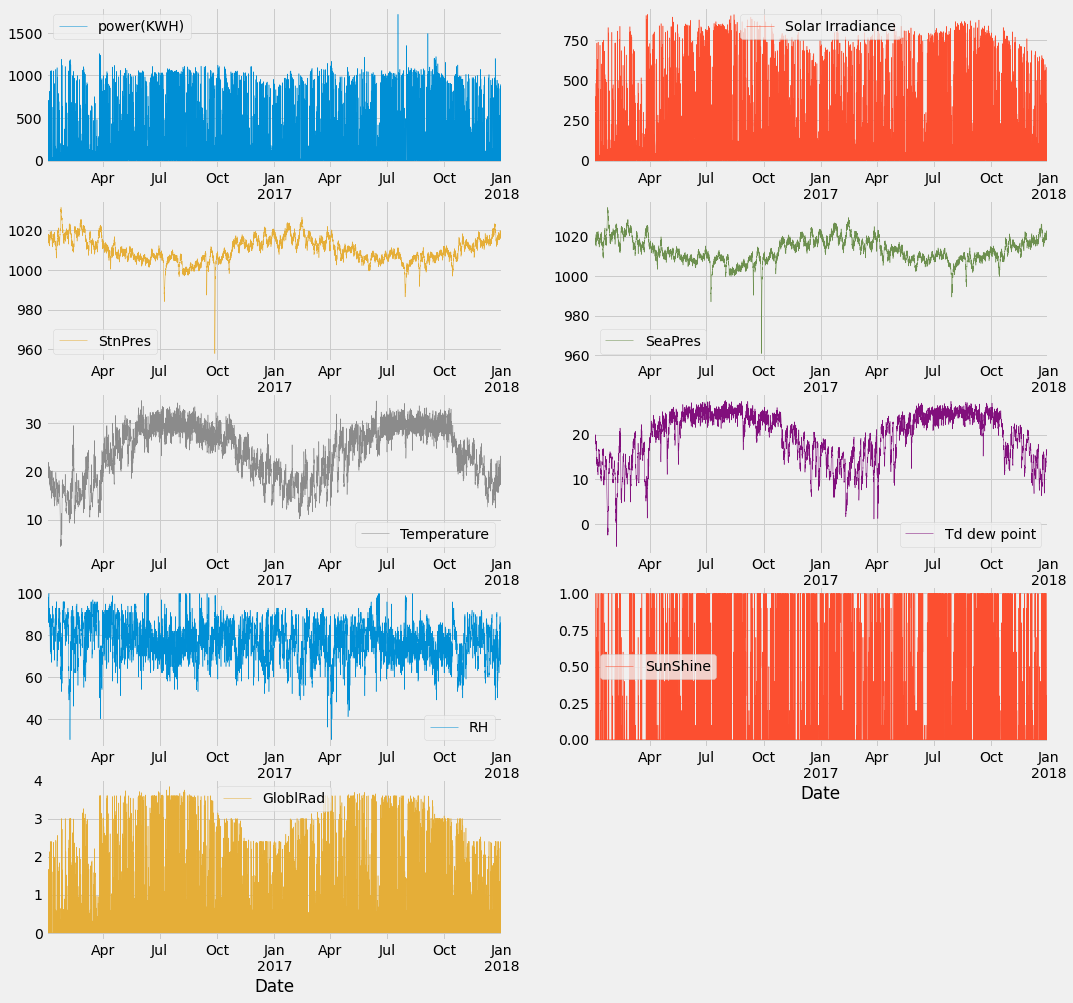

In [9]:
data.plot(subplots=True, linewidth=0.5, layout=(5, 2), figsize=(16, 16),
          sharex=False, sharey=False)
plt.show()


Consider normal distribution, 99.7% data bewteen  $ mean + 3 \times std $ and $ mean - 3 \times std $.  

We focus on PV forecast , so don't care night.

In [10]:
# replace out 3 times std data
def replace_out_data(series):
    series_mean = series.mean()
    series_std = series.std()
    upper = series_mean + 3 * series_std 
    lower = series_mean - 3 * series_std
    series_new = np.where(series > upper, upper, np.where(series < lower, lower, series))
    return series_new
# choose day time
daytime_idx = ((6<= data.index.hour) & (data.index.hour<= 18))

for col in data.columns:
    data.loc[daytime_idx,col] = replace_out_data(data.loc[daytime_idx,col])

print(data[daytime_idx].describe().transpose())

                   count         mean         std         min          25%  \
power(KWH)        9503.0   386.390656  349.470772    0.000000    56.000000   
Solar Irradiance  9503.0   290.880952  257.175962    0.000000    59.103591   
StnPres           9503.0  1010.017104    5.922215  991.783876  1005.900000   
SeaPres           9503.0  1013.114979    5.992838  994.676048  1009.000000   
Temperature       9503.0    24.368349    5.722668    7.162121    19.700000   
Td dew point      9503.0    19.659760    5.599656    2.742113    15.400000   
RH                9503.0    75.614142    9.091097   47.962242    70.000000   
SunShine          9503.0     0.435358    0.440178    0.000000     0.000000   
GloblRad          9503.0     1.201591    1.082599    0.000000     0.190000   

                          50%          75%          max  
power(KWH)         300.000000   682.000000  1435.202172  
Solar Irradiance   221.495688   495.414551   909.122505  
StnPres           1009.500000  1014.300000  1

Pearson correlation coefficient

$$ \rho_{XY} = corr(X,Y) = \frac {COV(X,Y)}{\sigma_{X}\sigma_{Y}} = \frac {E[(X-\mu_{X})(Y-\mu_{Y})]}{\sigma_{X}\sigma_{Y}}	 $$

$cov$  is the covariance

$ \sigma _{X} $ is the standard deviation of $ X $

$ \sigma _{Y} $ is the standard deviation of $ Y $

$ \mu _{X} $ is the mean of $X$

$ \mu _{Y} $ is the mean of $Y$

$E$ is the expectation.

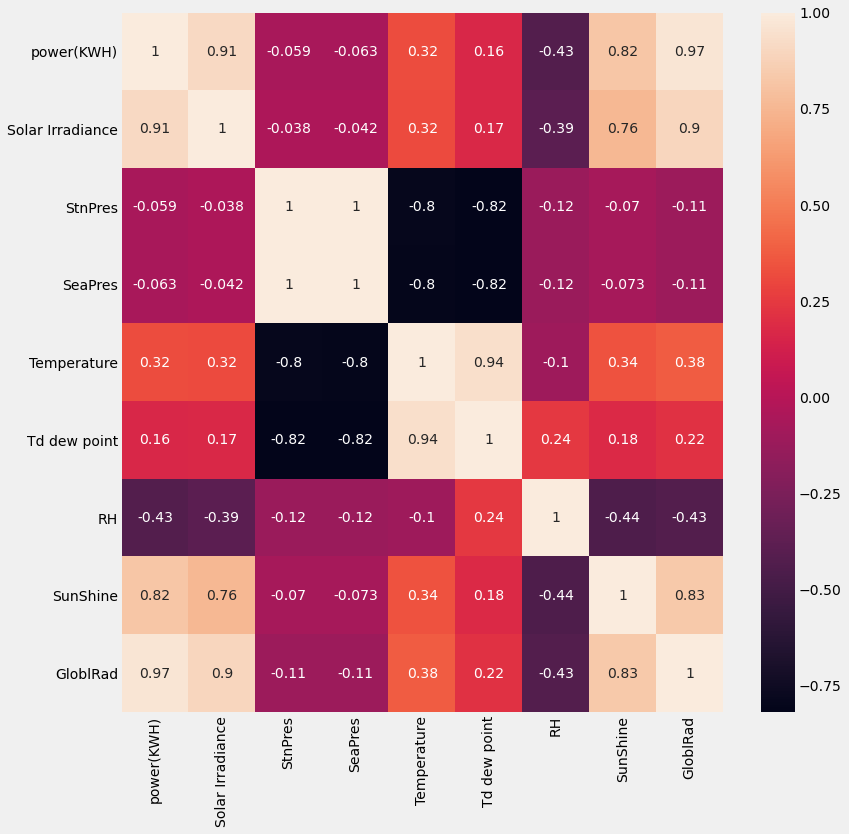

In [11]:
# Computing Correlation Matrices
corr_mat = data.corr(method='pearson')
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr_mat, annot=True)
plt.show()


High degree : abs(correlation) > 0.5

Moderate degree: 0.49 > abs(correlation) > 0.3

Low degree: 0.29 > abs(correlation)

We keep high degree data.

In [12]:
data_high_degree = data[['power(KWH)', 'SunShine', 'GloblRad', 'Solar Irradiance']]
# save data
data_high_degree.to_csv('data\Power_High_degree.csv', encoding='utf-8-sig')
data.to_csv('data\Taichung_Power_Weather.csv', encoding='utf-8-sig')